In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(
    "output_strat.txt",
    names=[
        "seed",
        "depth",
        "method",
        "budget",
        "skill",
        "epoch",
        "score",
        "best",
        "wait",
        "patience",
    ],
)

df = df[(df.wait == df.patience)]
df["skill"] = df[["depth", "skill"]].min(axis=1)
df = (
    df.groupby(["seed", "depth", "method", "budget", "skill"]).best.mean().reset_index()
)
df = df.sort_values(["budget", "depth", "seed", "method", "skill"])
df["best"] *= 1000

In [3]:
df.groupby(["method"]).apply(
    lambda x: x.pivot_table(
        columns="budget", index=["depth", "skill"], values="seed", aggfunc=[len]
    )
)

/tmp/ipykernel_2286986/1026659897.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(["method"]).apply(


len               
budget               1    10   100  1000
method   depth skill                    
binary   4     2      390  358  113  392
               4      390  340  116  392
         6     2      163  165   98  150
               4      168  161   73  150
               6      168  154   88  157
...                   ...  ...  ...  ...
streak-3 10    2      100  100   99   99
               4       99  100   98   96
               6      100  100   99   97
               8      100   99  100   99
               10      99  100   99   99

[70 rows x 4 columns]

4 binary


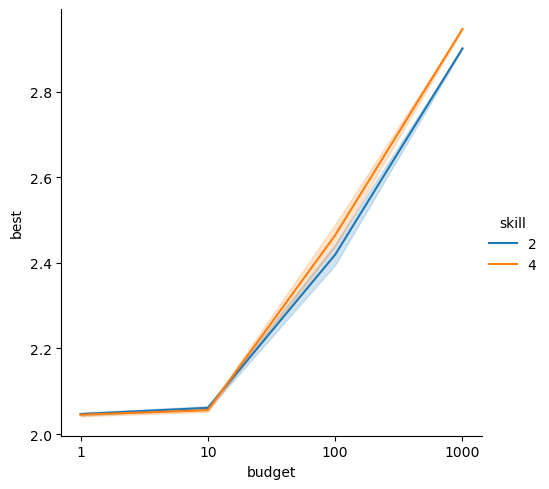

4 float


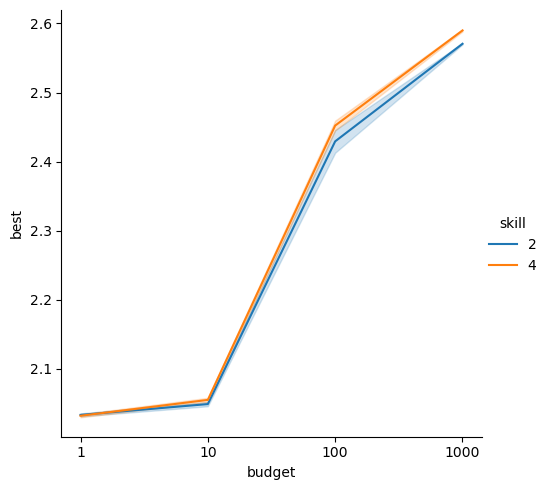

4 linear


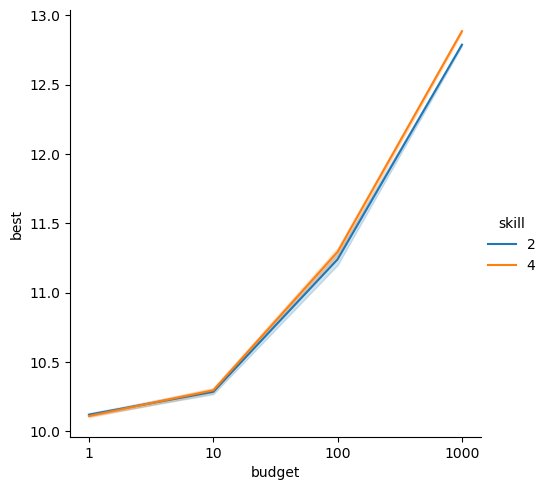

4 streak-2


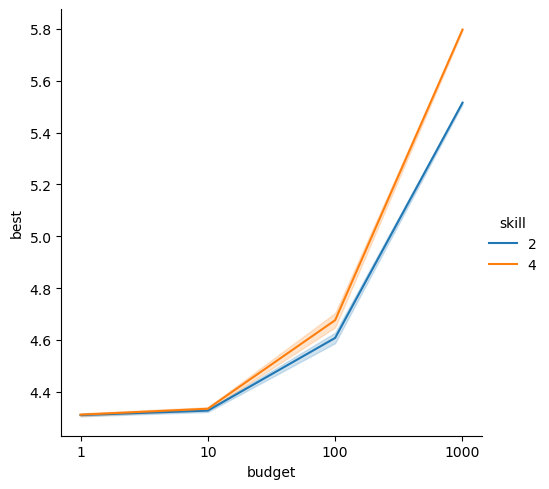

4 streak-3


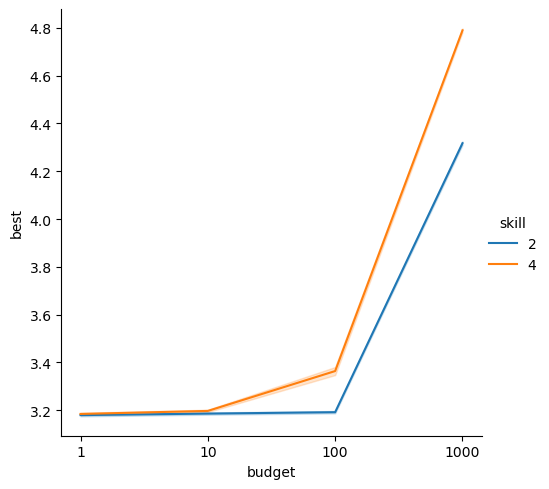

6 binary


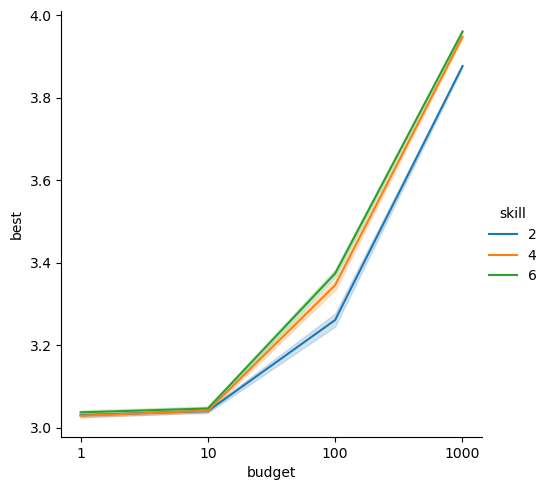

6 float


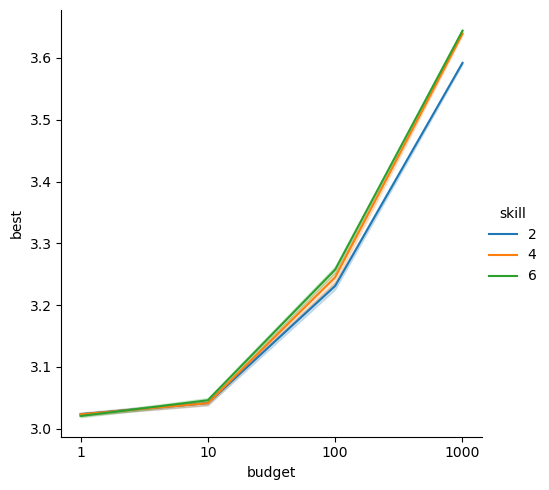

6 linear


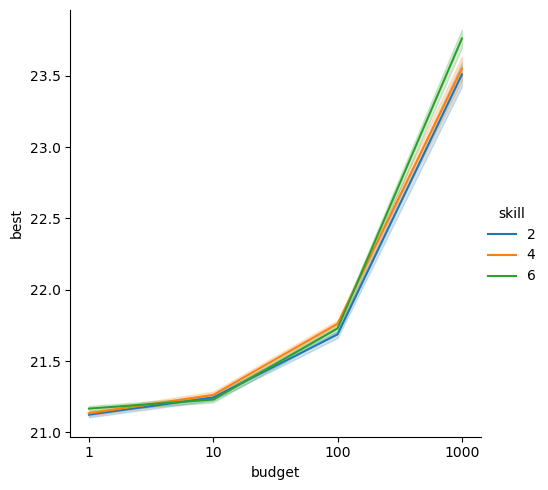

6 streak-2


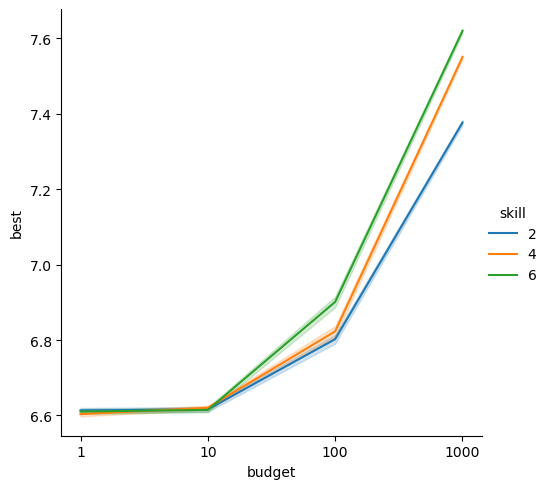

6 streak-3


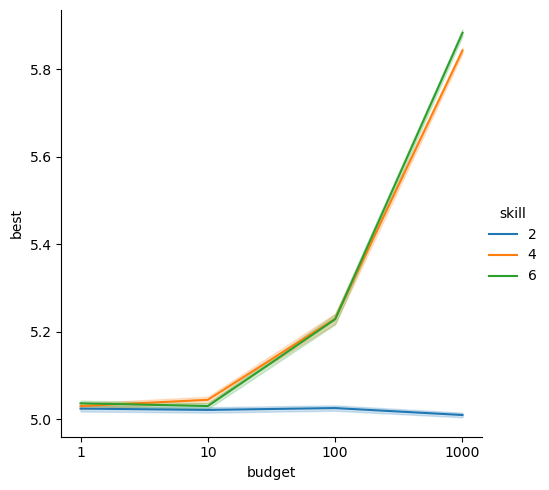

8 binary


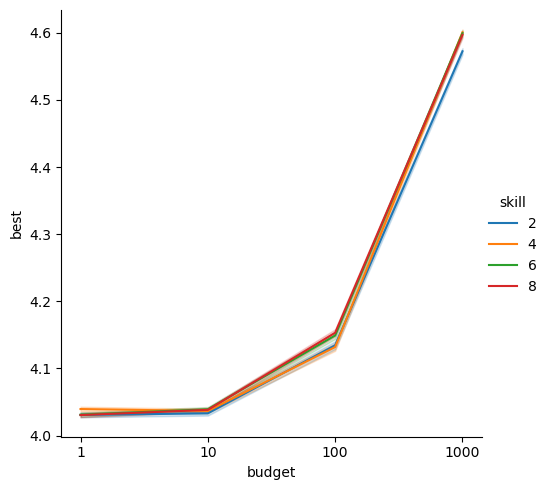

8 float


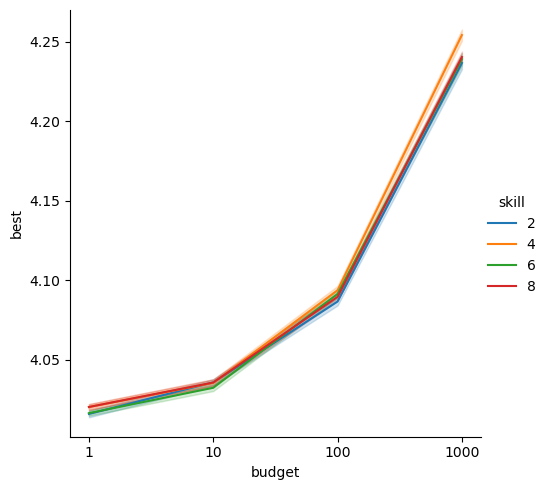

8 linear


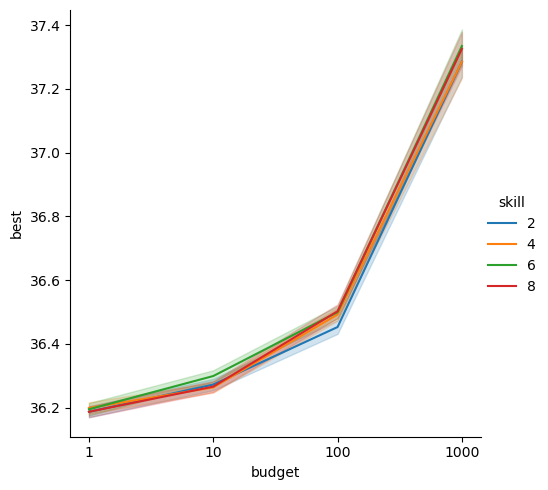

8 streak-2


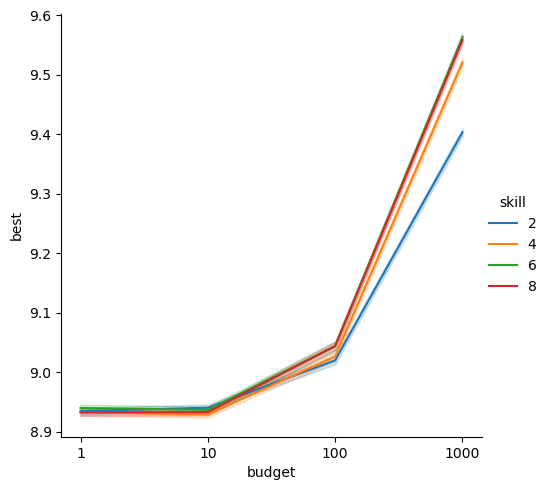

8 streak-3


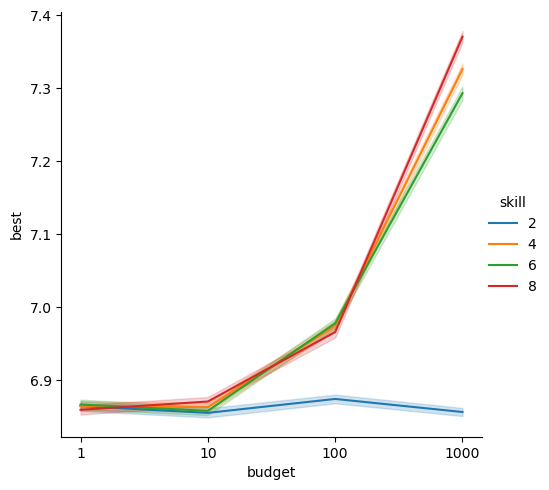

10 binary


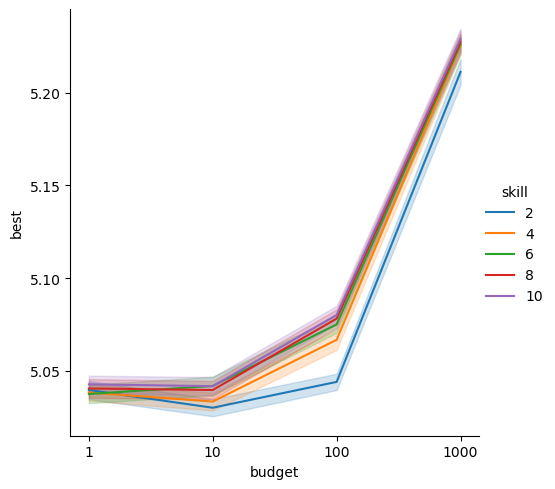

10 float


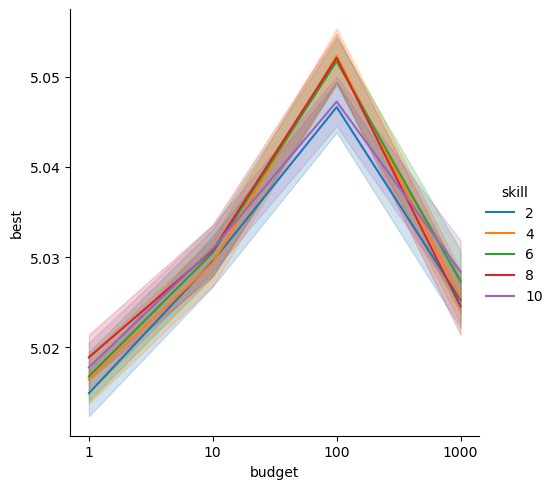

10 linear


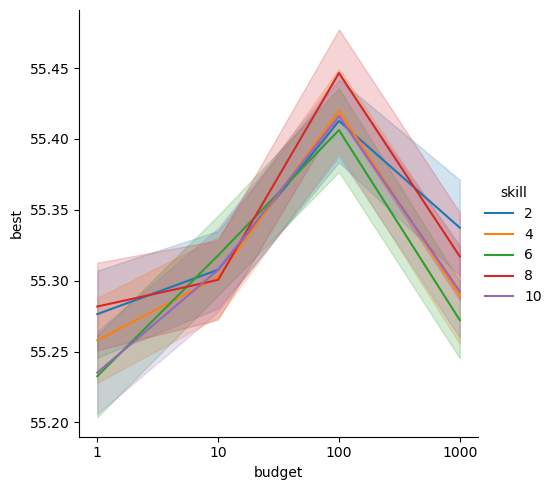

10 streak-2


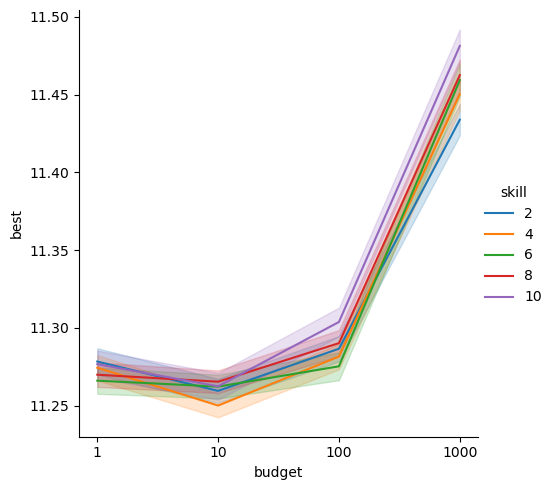

10 streak-3


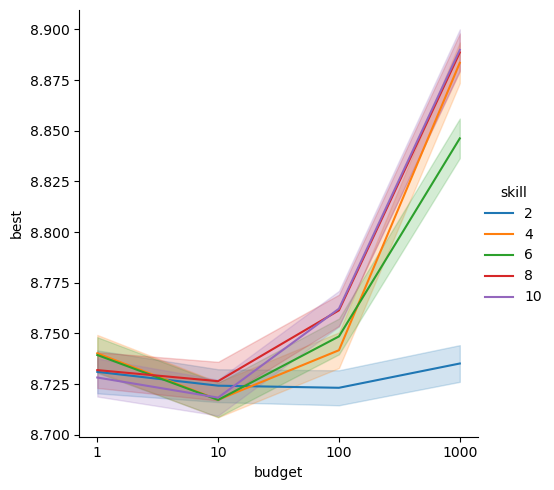

In [4]:
for (d, m), grp in df.groupby(["depth", "method"]):
    print(d, m)
    sns.relplot(
        data=grp.astype({"budget": "str", "skill": "str"}),
        x="budget",
        y="best",
        hue="skill",
        kind="line",
        errorbar="se",
    )
    plt.show()

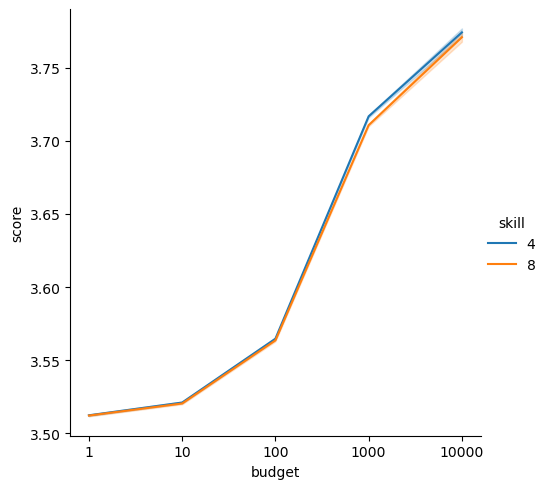

In [12]:
sns.relplot(
    data=df[(df.depth == 8) & (df.skill.isin([4, 8]))].astype(
        {"budget": "str", "skill": "str"}
    ),
    x="budget",
    y="score",
    hue="skill",
    kind="line",
    errorbar="se",
)

In [11]:
df[(df.depth == 10)].pivot_table(index="budget", columns="skill", values="score")

skill,0,2,4,6,8,10
budget,,,,,,
1,4.501035,4.500029,4.498871,4.499394,4.499670,4.499799
2,4.500828,4.500890,4.501292,4.501633,4.501069,4.501318
5,4.500920,4.499098,4.499848,4.498621,4.500439,4.499668
10,4.500932,4.501189,4.502875,4.501975,4.501562,4.501997
20,4.500911,4.501083,4.500986,4.502491,4.501891,4.502169
50,4.500940,4.501889,4.502818,4.503514,4.502461,4.502146
100,4.500898,4.508758,4.508230,4.508013,4.508394,4.508823
200,4.500900,4.516292,4.517744,4.518515,4.518054,4.517836
500,4.500951,4.515555,4.518239,4.517946,4.518084,4.516548
